In [58]:
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from prophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

### want to forecast the GDP per Capita per country for the next 7 to 10 years 

In [59]:
raw_data = pd.read_csv('gdp_raw_data.csv' , header=None )

In [60]:
raw_data.columns = ['demo_ind' ,'indicator' , 'location','country','time','value','flag codes','flags']

In [61]:
raw_data.head()

,demo_ind,indicator,location,country,time,value,flag codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN


In [62]:
df = raw_data.copy()

In [63]:
df = df.dropna(subset = ['value'])

In [64]:
df = df[['demo_ind','indicator','location','country','time','value']]

In [65]:
for col in df:
    un = np.unique(df[col])
    l = len(un)
    if l<10:
        print(f'No. of unique values for {col} column is {l} and are {un}')
    else:
        print(f'No. of unique values for {col} column is {l}')

No. of unique values for demo_ind column is 35
No. of unique values for indicator column is 35
No. of unique values for location column is 233
No. of unique values for country column is 233
No. of unique values for time column is 50
No. of unique values for value column is 125438


In [66]:
###Forecast_data --> df1###

df1 = df[df['indicator']== 'GDP per capita, PPP (current international $)']

In [67]:
df1 = df1[df1['country'].isin(['Australia'])]

In [68]:
df1.head()

,demo_ind,indicator,location,country,time,value
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89
76852,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81


In [69]:
df1 = df1[['country' , 'time' , 'value']]

In [70]:
df1['time'] = df1['time'].astype(str)+'-01-01'
df1['time'] = pd.to_datetime(df1['time'])

15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:26:47 - cmdstanpy - INFO - Chain [1] done processing
15:26:47 - cmdstanpy - INFO - Chain [1] start processing
15:26:48 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'AU'}, xlabel='time', ylabel='value'>

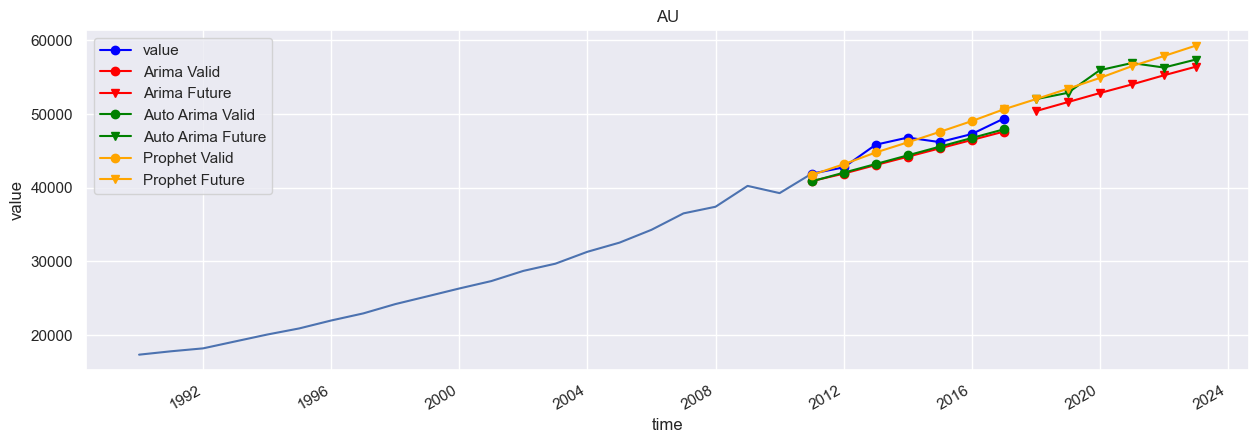

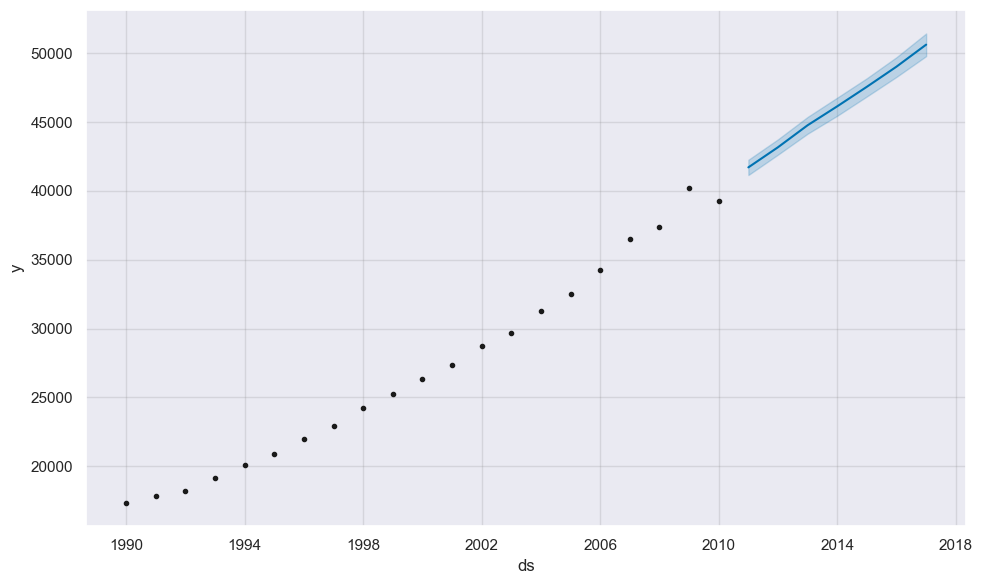

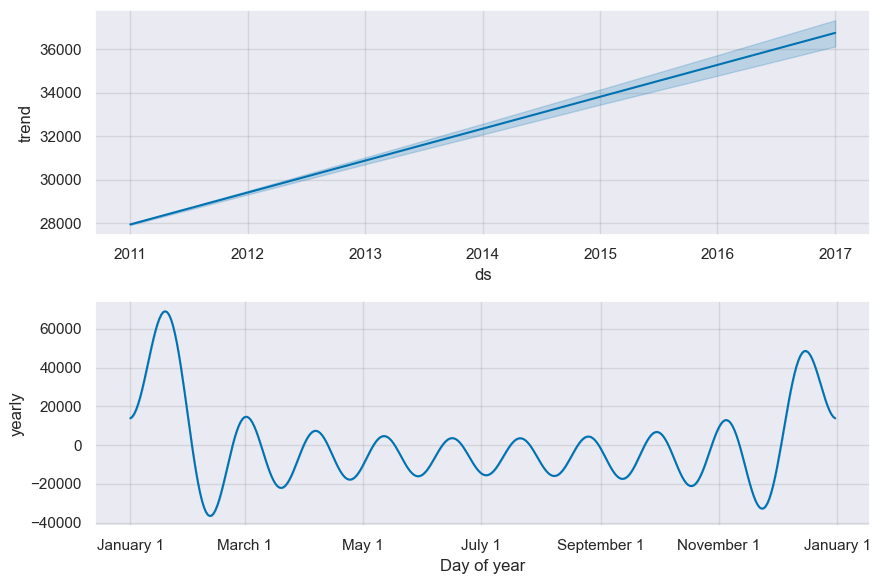

In [71]:
x_train = df1[df1['time'] < '2011-01-01']
x_valid = df1[df1['time'] >= '2011-01-01']

xtrain = x_train[['time' , 'value']]
xvalid = x_valid[['time' , 'value']]
alldata = df1[['time' , 'value']]

xtrain.set_index('time' , inplace =True)
xvalid.set_index('time' , inplace = True)
alldata.set_index('time' ,  inplace = True)

index_7_years = pd.date_range(start = xvalid.index[0] , freq='1AS' , periods=7)
future_index_7_years = pd.date_range(start = xvalid.index[-1] , freq='1AS' , periods=7)

### ARIMA - MODEL ###
model_arima = ARIMA(xtrain  , order = (3,1,2))
model_arima_fit = model_arima.fit()

fcast1 = model_arima_fit.forecast(7)
fcast1 = pd.Series(fcast1 , index= index_7_years)
fcast1 = fcast1.rename("Arima Valid")

model_arimaf = ARIMA(alldata , order=(3,1,2))
model_arimaf_fit = model_arimaf.fit()

f_fcast1 = model_arimaf_fit.forecast(7)
f_fcast1 = pd.Series(f_fcast1 , index = future_index_7_years)
f_fcast1 = f_fcast1.rename("Arima Future")

### AUTO_ARIMA_MODEL ###
model_auto_arima = pm.auto_arima(xtrain , seasonal=True , m=7)
        
fcast2 = model_auto_arima.predict(7)
fcast2 = pd.Series(fcast2 , index=index_7_years)
fcast2 = fcast2.rename("Auto Arima Valid")

model_auto_arimaf = pm.auto_arima(alldata , seasonal=True , m=7)

f_fcast2 = model_auto_arimaf.predict(7)
f_fcast2 = pd.Series(f_fcast2 , index = future_index_7_years)
f_fcast2 = f_fcast2.rename("Auto Arima Future")

### PROPHET MODEL ###

df2 = x_train.copy()
df2 = df2[['time' ,'value']]
df2.columns = ['ds' , 'y']
df2['ds'] = to_datetime(df2['ds'])

model = Prophet(yearly_seasonality=True)
model.fit(df2)


df_index_7_years = pd.DataFrame(index_7_years)
df_index_7_years.columns = ['ds']
df_index_7_years['ds']= to_datetime(df_index_7_years['ds'])
fcast3 = model.predict(df_index_7_years)
fcast4=fcast3
fcast3 = pd.Series(fcast3['yhat'].values , index = index_7_years)
fcast3 = fcast3.rename("Prophet Valid")

df3 = df1.copy()
df3 = df3[['time' , 'value']]
df3.columns = ['ds' , 'y']
df3['ds'] = to_datetime(df3['ds'])

modelf = Prophet(yearly_seasonality=True)
modelf.fit(df3)

df_f_index_7_years = pd.DataFrame(future_index_7_years)
df_f_index_7_years.columns = ['ds']
df_f_index_7_years['ds']= to_datetime(df_f_index_7_years['ds'])
f_fcast3 = model.predict(df_f_index_7_years)
f_fcast3 = pd.Series(f_fcast3['yhat'].values , index= future_index_7_years)
f_fcast3 = f_fcast3.rename("Prophet Future")
### PLOTTING ###

fig, ax = plt.subplots(figsize=(15,5))
aup  = df1[df1['time']<='2011-01-01']
chart = sns.lineplot(x='time', y='value', data = aup)
chart.set_title('AU')
model.plot(fcast4, uncertainty=True)
model.plot_components(fcast4)
xvalid.plot(ax=ax , color='blue' , marker="o" , legend=True)
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
f_fcast1.plot(ax=ax , color='red' , marker="v" , legend=True)
fcast2.plot(ax=ax, color='green', marker="o", legend=True)
f_fcast2.plot(ax=ax , color='green' , marker="v" , legend=True)
fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
f_fcast3.plot(ax=ax , color='orange' , marker="v" , legend=True)




In [72]:
print('Sum of Squares of residuals in arima is' ,r2_score(xvalid , fcast1))
print('Sum of Squares of residuals in auto-arima is' ,r2_score( xvalid , fcast2))
print('Sum of Squares of residuals in  prophet is' ,r2_score(xvalid, fcast3))

print('Mean squared error in arima is' , mean_squared_error(xvalid , fcast1 , squared=False))
print('Mean squared error in auto-arima is' , mean_squared_error(xvalid , fcast2, squared=False))
print('Mean squared error in prophet is' , mean_squared_error(xvalid , fcast3 , squared=False))



Sum of Squares of residuals in arima is 0.49263309885091044
Sum of Squares of residuals in auto-arima is 0.5785863937118476
Sum of Squares of residuals in  prophet is 0.7951523331471986
Mean squared error in arima is 1716.3725333921097
Mean squared error in auto-arima is 1564.244969138217
Mean squared error in prophet is 1090.6012747522543
